In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import pickle
from tool.my_dataset import get_dataset_dataloader
from tool.dacon_eval import evaluate_scores
from tool.my_model import HawonNet
from tool.etc import pearson_correlation, pIC50_to_IC50
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
# train/test/id_to_y 생성
use_inequality = False # 부등호 데이터 쓸지

if use_inequality:
    tr_key_dir = '/home/tech/Hawon/Dacon/data/toygnn_data/inequality_included_keys/public_train_keys.pkl'
    vl_key_dir = '/home/tech/Hawon/Dacon/data/toygnn_data/inequality_included_keys/public_val_keys.pkl'
else:
    tr_key_dir = '/home/tech/Hawon/Dacon/data/toygnn_data/equality_only_keys/public_train_keys.pkl'
    vl_key_dir = '/home/tech/Hawon/Dacon/data/toygnn_data/equality_only_keys/public_val_keys.pkl'
    
with open(tr_key_dir, 'rb') as fp:
    tr_keys = pickle.load(fp)
with open(vl_key_dir, 'rb') as fp:
    val_keys = pickle.load(fp)
with open('/home/tech/Hawon/Dacon/data/toygnn_data/id_to_y.pkl', 'rb') as fp:
    id_to_y = pickle.load(fp)

In [6]:
# 인자 정의
class args:
    def __init__(self):
        self.batch_size = 32
        self.gnn_n_layer = 3
        self.gnn_hidden_dim = 128
        self.ngpu = 1
        self.total_data_dir = '/home/tech/Hawon/Dacon/data/toygnn_data/train/Dump'
        self.test_data_dir = '/home/hawon/Develop/Dacon/data/toygnn_data/train_test_dump'
        self.filename = "./data/pdbbind_v2019/scoring/pdb_to_affinity.txt"
        self.key_dir = "./data/pdbbind_v2019/scoring/keys"
        self.num_workers = 12
        self.num_epochs = 1000
        self.dropout_rate = 0.1
        self.lr = 0.0005
        self.save_model = True
        self.distance_bins = 15
        self.use_residue_node = False # False -> protein pocket의 atom만을 노드로 사용 (True면 whole amino acid를 노드로 사용)
        self.gnn_layer_type = 'AttentiveFP' # GCN or AttentiveFP
        self.int_projection_dim = 32 # 15차원의 interaction edge를 몇차원으로 projection하여 ligand_h, target_h 와 concat할지를 결정
hawon_args = args()

### 학습

In [7]:
# MAIN CODE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = HawonNet(hawon_args)
checkpoint = torch.load('/home/tech/Hawon/Dacon/code/MAIN/trial5_attentiveFP_ToyGNN/ToyGNN/ckpt/save/pretrained_AttentiveFP_resnodeFalse.pth')
model.load_state_dict(checkpoint)
model.to(device)
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=hawon_args.lr)

# 스케쥴러 / 얼리스탑 정의
scheduler = ReduceLROnPlateau(optim, mode='max', factor=0.1, patience=5)
patience = 15
min_delta = 0.001
best_val_dacon_for_early = -float('inf')

# best model save
best_val_dacon = -1
best_val_mse = np.Inf
best_model_path = './ckpt/best_model.pth'

# for speed
scaler = torch.cuda.amp.GradScaler()

train_dataset, train_dataloader = get_dataset_dataloader(keys = tr_keys, 
                                                         data_dir = hawon_args.total_data_dir, 
                                                         id_to_y = id_to_y, 
                                                         batch_size = hawon_args.batch_size, 
                                                         num_workers = hawon_args.num_workers, 
                                                         residue_node = hawon_args.use_residue_node,
                                                         train = True,
                                                         inference=False) # train -> shuffle 여부

val_dataset, val_dataloader = get_dataset_dataloader(keys = val_keys, 
                                                     data_dir = hawon_args.total_data_dir, 
                                                     id_to_y = id_to_y, 
                                                     batch_size = hawon_args.batch_size, 
                                                     num_workers = hawon_args.num_workers, 
                                                     residue_node = hawon_args.use_residue_node,
                                                     train = False,
                                                     inference=False)

print(f'Data load done: train {len(train_dataset)}, val {len(val_dataset)}')

tr_mse, vl_mse, tr_pc, vl_pc, best_result = [], [], [], [], {}
tr_dacon_score, vl_dacon_score = [], []

# 학습 루프

print(f'''OPTIONS
- epoch: {hawon_args.num_epochs}
- batch_size: {hawon_args.batch_size}
- num_workers: {hawon_args.num_workers}
- lr: {hawon_args.lr}
- gnn_type : {hawon_args.gnn_layer_type}
- gnn_n_layer: {hawon_args.gnn_n_layer}
- gnn_h_dim : {hawon_args.gnn_hidden_dim}
- residue_node : {hawon_args.use_residue_node}
=================================
''')

for epoch in range(hawon_args.num_epochs):
    # train
    model.train()
    train_loss = 0.0
    train_labels = torch.tensor([])
    train_predicts = torch.tensor([])
    for batch_idx, sample in enumerate(tqdm(train_dataloader)):
        # put sample on device
        for key, value in sample.items():
            if isinstance(value, torch.Tensor):
                value = value.to(device)
                sample[key] = value
        optim.zero_grad()
        train_pred = model(sample).squeeze()
        loss = criterion(train_pred, sample['affinity'])
        loss.backward()
        optim.step()
        train_loss += loss.item() * sample['affinity'].size(0)
        train_labels = torch.concat([train_labels, sample['affinity'].cpu()])
        train_predicts = torch.concat([train_predicts, train_pred.cpu()])
        torch.cuda.empty_cache()

    # validation
    model.eval()
    val_loss = 0.0
    val_labels = torch.tensor([])
    val_predicts = torch.tensor([])
    with torch.no_grad():
        for batch_idx, sample in enumerate(tqdm(val_dataloader)):
            # put sample on device
            for key, value in sample.items():
                if isinstance(value, torch.Tensor):
                    value = value.to(device)
                    sample[key] = value
            val_pred = model(sample).squeeze()
            loss = criterion(val_pred, sample['affinity'])
            val_loss += loss.item() * sample['affinity'].size(0)
            val_labels = torch.cat([val_labels, sample['affinity'].cpu()])
            val_predicts = torch.cat([val_predicts, val_pred.cpu()])

    # MSE/PC 계산
    train_labels = train_labels.detach().numpy()
    train_predicts = train_predicts.detach().numpy()
    val_labels = val_labels.detach().numpy()
    val_predicts = val_predicts.detach().numpy()
    
    train_mse = train_loss / len(train_dataset)
    val_mse = val_loss / len(val_dataset)
    train_pearson = pearson_correlation(train_labels, train_predicts).item()
    val_pearson = pearson_correlation(val_labels, val_predicts).item()
    train_dacon = evaluate_scores(pIC50_to_IC50(train_labels), pIC50_to_IC50(train_predicts))[0].item()
    val_dacon = evaluate_scores(pIC50_to_IC50(val_labels), pIC50_to_IC50(val_predicts))[0].item()
    
    # scheduler step
    scheduler.step(val_dacon)
    
    # 로깅
    print(f'epoch:{epoch+1} | train_mse(pic50):{train_mse:.2f} | val_mse(pic50):{val_mse:.2f} | train_dacon(ic50): {train_dacon:.2f} | val_dacon(ic50): {val_dacon:.2f} | train_pearson:{train_pearson:.2f} | val_pearson:{val_pearson:.2f}')
    tr_mse.append(train_mse)
    vl_mse.append(val_mse)
    tr_pc.append(train_pearson)
    vl_pc.append(val_pearson)
    tr_dacon_score.append(train_dacon)
    vl_dacon_score.append(val_dacon)
    
    # 모델 저장 & early stop
    if hawon_args.save_model:
        if val_dacon >= best_val_dacon + min_delta:
            best_val_dacon = val_dacon
            torch.save(model.state_dict(), best_model_path)
            print(f'New best model saved based on val_dacon -> epoch: {epoch+1}, val_mse: {val_mse:.2f}, val_dacon: {best_val_dacon:.2f}')
            best_result['best_val_mse'] = best_val_mse
            best_result['best_val_dacon'] = best_val_dacon
            best_result['epoch'] = epoch+1
            counter = 0
        elif val_mse <= best_val_mse - min_delta:
            best_val_mse = val_mse
            torch.save(model.state_dict(), best_model_path)
            print(f'New best model saved based on val_mse -> epoch: {epoch+1}, val_mse: {best_val_mse:.2f}, val_dacon: {val_dacon:.2f}')
            best_result['best_val_mse'] = best_val_mse
            best_result['best_val_dacon'] = best_val_dacon
            best_result['epoch'] = epoch+1
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopped at epoch {epoch + 1} !')
                break
    print(f'-----------------------------------------------------------------')

Data load done: train 8493, val 447
OPTIONS
- epoch: 1000
- batch_size: 32
- num_workers: 12
- lr: 0.0005
- gnn_type : AttentiveFP
- gnn_n_layer: 3
- gnn_h_dim : 128
- residue_node : False



100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


epoch:1 | train_mse(pic50):1.38 | val_mse(pic50):1.04 | train_dacon(ic50): 0.65 | val_dacon(ic50): 0.64 | train_pearson:0.28 | val_pearson:0.45
New best model saved based on val_dacon -> epoch: 1, val_mse: 1.04, val_dacon: 0.64
-----------------------------------------------------------------


100%|██████████| 14/14 [00:05<00:00,  2.39it/s]


epoch:2 | train_mse(pic50):1.22 | val_mse(pic50):0.98 | train_dacon(ic50): 0.65 | val_dacon(ic50): 0.62 | train_pearson:0.35 | val_pearson:0.51
New best model saved based on val_dacon -> epoch: 2, val_mse: 0.98, val_dacon: 0.62
-----------------------------------------------------------------


100%|██████████| 14/14 [00:06<00:00,  2.14it/s]


epoch:3 | train_mse(pic50):1.19 | val_mse(pic50):0.97 | train_dacon(ic50): 0.66 | val_dacon(ic50): 0.63 | train_pearson:0.38 | val_pearson:0.52
New best model saved based on val_dacon -> epoch: 3, val_mse: 0.97, val_dacon: 0.63
-----------------------------------------------------------------


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


epoch:4 | train_mse(pic50):1.15 | val_mse(pic50):1.10 | train_dacon(ic50): 0.68 | val_dacon(ic50): 0.60 | train_pearson:0.41 | val_pearson:0.54
-----------------------------------------------------------------


100%|██████████| 14/14 [00:06<00:00,  2.14it/s]


epoch:5 | train_mse(pic50):1.13 | val_mse(pic50):0.88 | train_dacon(ic50): 0.67 | val_dacon(ic50): 0.67 | train_pearson:0.43 | val_pearson:0.57
New best model saved based on val_dacon -> epoch: 5, val_mse: 0.88, val_dacon: 0.67
-----------------------------------------------------------------


100%|██████████| 14/14 [00:06<00:00,  2.17it/s]


epoch:6 | train_mse(pic50):1.10 | val_mse(pic50):0.86 | train_dacon(ic50): 0.67 | val_dacon(ic50): 0.66 | train_pearson:0.44 | val_pearson:0.59
New best model saved based on val_dacon -> epoch: 6, val_mse: 0.86, val_dacon: 0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


epoch:7 | train_mse(pic50):1.07 | val_mse(pic50):0.89 | train_dacon(ic50): 0.68 | val_dacon(ic50): 0.65 | train_pearson:0.47 | val_pearson:0.59
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  4.02it/s]


epoch:8 | train_mse(pic50):1.09 | val_mse(pic50):0.84 | train_dacon(ic50): 0.67 | val_dacon(ic50): 0.66 | train_pearson:0.46 | val_pearson:0.61
New best model saved based on val_dacon -> epoch: 8, val_mse: 0.84, val_dacon: 0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.78it/s]


epoch:9 | train_mse(pic50):1.07 | val_mse(pic50):0.83 | train_dacon(ic50): 0.68 | val_dacon(ic50): 0.66 | train_pearson:0.47 | val_pearson:0.60
New best model saved based on val_dacon -> epoch: 9, val_mse: 0.83, val_dacon: 0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.97it/s]


epoch:10 | train_mse(pic50):1.04 | val_mse(pic50):0.96 | train_dacon(ic50): 0.67 | val_dacon(ic50): 0.64 | train_pearson:0.49 | val_pearson:0.57
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.97it/s]


epoch:11 | train_mse(pic50):1.02 | val_mse(pic50):1.88 | train_dacon(ic50): 0.67 | val_dacon(ic50): 0.53 | train_pearson:0.50 | val_pearson:0.43
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.97it/s]


epoch:12 | train_mse(pic50):1.00 | val_mse(pic50):0.78 | train_dacon(ic50): 0.67 | val_dacon(ic50): 0.68 | train_pearson:0.52 | val_pearson:0.64
New best model saved based on val_dacon -> epoch: 12, val_mse: 0.78, val_dacon: 0.68
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.94it/s]


epoch:13 | train_mse(pic50):1.00 | val_mse(pic50):0.81 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.66 | train_pearson:0.52 | val_pearson:0.63
New best model saved based on val_dacon -> epoch: 13, val_mse: 0.81, val_dacon: 0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.92it/s]


epoch:14 | train_mse(pic50):0.99 | val_mse(pic50):0.76 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.68 | train_pearson:0.52 | val_pearson:0.65
New best model saved based on val_dacon -> epoch: 14, val_mse: 0.76, val_dacon: 0.68
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  4.12it/s]


epoch:15 | train_mse(pic50):0.96 | val_mse(pic50):0.78 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.69 | train_pearson:0.54 | val_pearson:0.64
New best model saved based on val_dacon -> epoch: 15, val_mse: 0.78, val_dacon: 0.69
-----------------------------------------------------------------


100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


epoch:16 | train_mse(pic50):0.96 | val_mse(pic50):0.77 | train_dacon(ic50): 0.68 | val_dacon(ic50): 0.67 | train_pearson:0.54 | val_pearson:0.65
New best model saved based on val_dacon -> epoch: 16, val_mse: 0.77, val_dacon: 0.67
-----------------------------------------------------------------


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


epoch:17 | train_mse(pic50):0.97 | val_mse(pic50):0.80 | train_dacon(ic50): 0.68 | val_dacon(ic50): 0.67 | train_pearson:0.53 | val_pearson:0.65
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.50it/s]


epoch:18 | train_mse(pic50):0.96 | val_mse(pic50):0.78 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.67 | train_pearson:0.54 | val_pearson:0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  4.10it/s]


epoch:19 | train_mse(pic50):0.98 | val_mse(pic50):0.77 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.68 | train_pearson:0.53 | val_pearson:0.65
-----------------------------------------------------------------


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


epoch:20 | train_mse(pic50):0.97 | val_mse(pic50):0.75 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.68 | train_pearson:0.54 | val_pearson:0.66
New best model saved based on val_dacon -> epoch: 20, val_mse: 0.75, val_dacon: 0.68
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.96it/s]


epoch:21 | train_mse(pic50):0.98 | val_mse(pic50):0.77 | train_dacon(ic50): 0.68 | val_dacon(ic50): 0.67 | train_pearson:0.53 | val_pearson:0.65
-----------------------------------------------------------------


100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


epoch:22 | train_mse(pic50):0.97 | val_mse(pic50):0.76 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.67 | train_pearson:0.53 | val_pearson:0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


epoch:23 | train_mse(pic50):0.95 | val_mse(pic50):0.74 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.68 | train_pearson:0.54 | val_pearson:0.66
New best model saved based on val_dacon -> epoch: 23, val_mse: 0.74, val_dacon: 0.68
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


epoch:24 | train_mse(pic50):0.96 | val_mse(pic50):0.73 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.68 | train_pearson:0.54 | val_pearson:0.67
New best model saved based on val_dacon -> epoch: 24, val_mse: 0.73, val_dacon: 0.68
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.90it/s]


epoch:25 | train_mse(pic50):0.98 | val_mse(pic50):0.73 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.68 | train_pearson:0.53 | val_pearson:0.67
-----------------------------------------------------------------


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


epoch:26 | train_mse(pic50):0.97 | val_mse(pic50):0.74 | train_dacon(ic50): 0.68 | val_dacon(ic50): 0.67 | train_pearson:0.54 | val_pearson:0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:04<00:00,  3.41it/s]


epoch:27 | train_mse(pic50):0.96 | val_mse(pic50):0.73 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.67 | train_pearson:0.54 | val_pearson:0.67
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.93it/s]


epoch:28 | train_mse(pic50):0.97 | val_mse(pic50):0.73 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.67 | train_pearson:0.53 | val_pearson:0.67
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  4.07it/s]


epoch:29 | train_mse(pic50):0.95 | val_mse(pic50):0.74 | train_dacon(ic50): 0.68 | val_dacon(ic50): 0.67 | train_pearson:0.55 | val_pearson:0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.91it/s]


epoch:30 | train_mse(pic50):0.96 | val_mse(pic50):0.75 | train_dacon(ic50): 0.68 | val_dacon(ic50): 0.67 | train_pearson:0.54 | val_pearson:0.67
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.96it/s]


epoch:31 | train_mse(pic50):0.97 | val_mse(pic50):0.76 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.68 | train_pearson:0.54 | val_pearson:0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.94it/s]


epoch:32 | train_mse(pic50):0.96 | val_mse(pic50):0.74 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.68 | train_pearson:0.54 | val_pearson:0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.98it/s]


epoch:33 | train_mse(pic50):0.95 | val_mse(pic50):0.75 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.67 | train_pearson:0.55 | val_pearson:0.67
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  4.09it/s]


epoch:34 | train_mse(pic50):0.94 | val_mse(pic50):0.75 | train_dacon(ic50): 0.68 | val_dacon(ic50): 0.68 | train_pearson:0.55 | val_pearson:0.67
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.98it/s]


epoch:35 | train_mse(pic50):0.96 | val_mse(pic50):0.74 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.68 | train_pearson:0.54 | val_pearson:0.67
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  4.05it/s]


epoch:36 | train_mse(pic50):0.97 | val_mse(pic50):0.74 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.67 | train_pearson:0.54 | val_pearson:0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  3.59it/s]


epoch:37 | train_mse(pic50):0.97 | val_mse(pic50):0.74 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.68 | train_pearson:0.54 | val_pearson:0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


epoch:38 | train_mse(pic50):0.97 | val_mse(pic50):0.75 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.67 | train_pearson:0.54 | val_pearson:0.66
-----------------------------------------------------------------


100%|██████████| 14/14 [00:03<00:00,  4.00it/s]


epoch:39 | train_mse(pic50):0.96 | val_mse(pic50):0.75 | train_dacon(ic50): 0.69 | val_dacon(ic50): 0.66 | train_pearson:0.54 | val_pearson:0.66
Early stopped at epoch 39 !


In [11]:
# 로깅
with open('train_logs/tr_mse.pkl', 'wb') as fp:
    pickle.dump(tr_mse, fp)
with open('train_logs/vl_mse.pkl', 'wb') as fp:
    pickle.dump(vl_mse, fp)
with open('train_logs/tr_pc.pkl', 'wb') as fp:
    pickle.dump(tr_pc, fp)
with open('train_logs/vl_pc.pkl', 'wb') as fp:
    pickle.dump(vl_pc, fp)
with open('train_logs/best_result.pkl', 'wb') as fp:
    pickle.dump(best_result, fp)

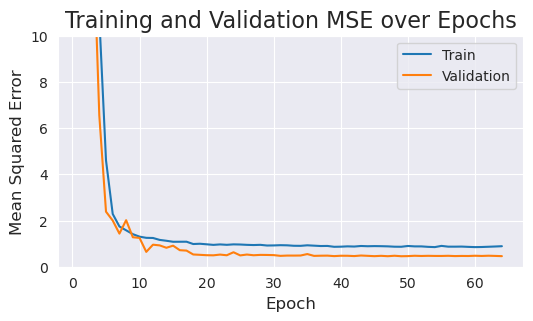

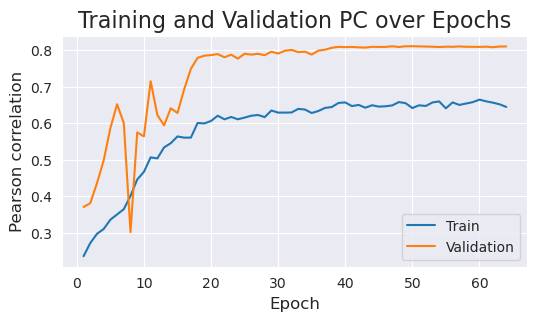

In [12]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

epochs = range(1, len(tr_mse)+1)

df = pd.DataFrame({
    'Epoch': list(epochs) * 2,
    'MSE': list(tr_mse) + list(vl_mse),
    'Type': ['Train'] * len(epochs) + ['Validation'] * len(epochs)
})

# seaborn 설정
sns.set_style("darkgrid")
plt.figure(figsize=(6, 3))

# 라인 플롯 그리기
sns.lineplot(x='Epoch', y='MSE', hue='Type', data=df)

# 그래프 제목과 레이블 설정
plt.title('Training and Validation MSE over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.ylim(0,10)
# 범례 위치 조정
plt.legend(title='', loc='upper right', fontsize=10)

# 그래프 표시
plt.show()

##########################

df = pd.DataFrame({
    'Epoch': list(epochs) * 2,
    'Pearson': list(tr_pc) + list(vl_pc),
    'Type': ['Train'] * len(epochs) + ['Validation'] * len(epochs)
})

# seaborn 설정
sns.set_style("darkgrid")
plt.figure(figsize=(6, 3))

# 라인 플롯 그리기
sns.lineplot(x='Epoch', y='Pearson', hue='Type', data=df)

# 그래프 제목과 레이블 설정
plt.title('Training and Validation PC over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Pearson correlation', fontsize=12)

# 범례 위치 조정
plt.legend(title='', loc='lower right', fontsize=10)

# 그래프 표시
plt.show()

In [13]:
# get best score
print(f'tr_mse 최소 : {min(tr_mse):.2f} at epoch {tr_mse.index(min(tr_mse))}')
print(f'vl_mse 최소 : {min(vl_mse):.2f} at epoch {vl_mse.index(min(vl_mse))}')
print(f'tr_pc 최대 : {max(tr_pc):.2f} at epoch {tr_pc.index(max(tr_pc))}')
print(f'vl_pc 최대 : {max(vl_pc):.2f} at epoch {vl_pc.index(max(vl_pc))}')
print(f'best_epoch: {best_result}')

tr_mse 최소 : 0.85 at epoch 53
vl_mse 최소 : 0.45 at epoch 48
tr_pc 최대 : 0.66 at epoch 59
vl_pc 최대 : 0.81 at epoch 49
best_epoch: {'best_val_mse': 0.45438535428153853, 'best_val_dacon': 0.7559630144178198, 'epoch': 49}
